In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point, LineString
# import itertools
from scipy.interpolate import InterpolatedUnivariateSpline

from load_data import get_pos, get_spikes
from maze_functions import find_zones, trajectory_fields
from plotting_functions import plot_intersects, plot_zone
from decode_functions import get_edges

import vdmlab as vdm

In [2]:
xy = np.array([[2, 7],
               [4, 5],
               [6, 3],
               [8, 1],
               [2, 4]])
time = np.array([0., 1., 2., 3., 4.])
position = vdm.Position(xy, time)

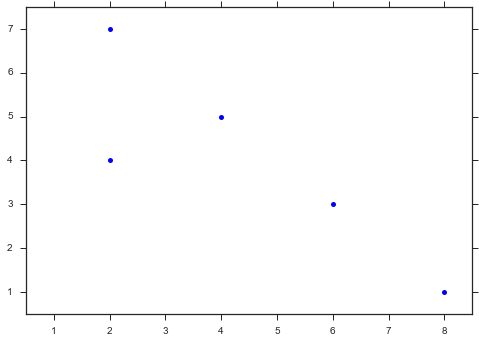

In [3]:
plt.plot(position.x, position.y, 'b.', ms=10)
plt.xlim(0.5, 8.5)
plt.ylim(0.5, 7.5)
plt.show()

In [4]:
spikes = [vdm.SpikeTrain(np.array([3.6, 3.9])), 
          vdm.SpikeTrain(np.array([0., 0., 2.])),
          vdm.SpikeTrain(np.array([2., 2.4]))]

In [5]:
binsize = 2
xedges = np.arange(position.x.min(), position.x.max()+binsize, binsize)
yedges = np.arange(position.y.min(), position.y.max()+binsize, binsize)

tuning_curves = vdm.tuning_curve_2d(position, spikes, xedges, yedges, sampling_rate=1.)

Tuning curves with no filter.


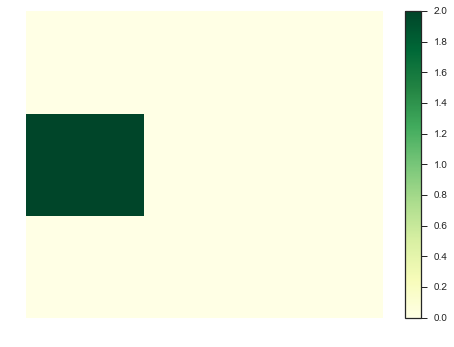

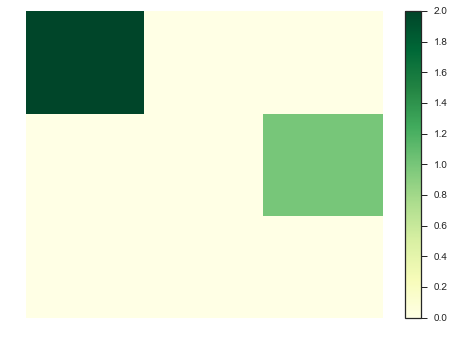

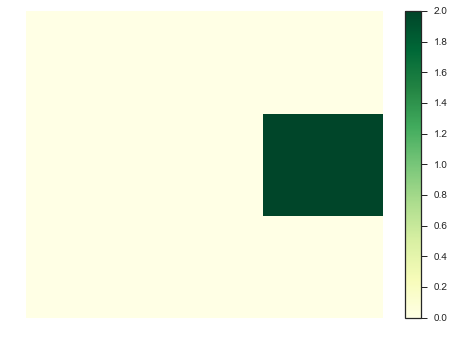

In [6]:
plt.figure()
xx, yy = np.meshgrid(xedges, yedges)
for tuning_curve in tuning_curves:
    pp = plt.pcolormesh(xx, yy, tuning_curve, cmap='YlGn')
    plt.colorbar(pp)
    plt.axis('off')
    plt.show()

In [7]:
counts_binsize = 0.5

time_edges = get_edges(position, counts_binsize, lastbin=True)
counts = vdm.get_counts(spikes, time_edges, apply_filter=False)

In [8]:
print(time_edges)

[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4. ]


In [9]:
print(counts)

[[ 0.  0.  0.  0.  0.  0.  0.  2.]
 [ 2.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  2.  0.  0.  0.]]


In [10]:
decoding_tc = []
for tuning_curve in tuning_curves:
    decoding_tc.append(np.ravel(tuning_curve))
decoding_tc = np.array(decoding_tc)

In [11]:
shape = tuning_curves[0].shape

In [12]:
tuning_curves

[array([[ 0.,  0.,  0.],
        [ 2.,  0.,  0.],
        [ 0.,  0.,  0.]]), array([[ 0.,  0.,  0.],
        [ 0.,  0.,  1.],
        [ 2.,  0.,  0.]]), array([[ 0.,  0.,  0.],
        [ 0.,  0.,  2.],
        [ 0.,  0.,  0.]])]

In [13]:
decoding_tc

array([[ 0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  2.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.]])

In [14]:
likelihood = vdm.bayesian_prob(counts, decoding_tc, counts_binsize)

In [15]:
likelihood

array([[        nan,         nan,         nan,  0.16666667,         nan,
         0.16666667,  0.66666667,         nan,         nan],
       [        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,  0.14285714,         nan,
         0.57142857,  0.28571429,         nan,         nan],
       [        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,  0.66666667,   

In [16]:
xcenters = (xedges[1:] + xedges[:-1]) / 2.
ycenters = (yedges[1:] + yedges[:-1]) / 2.
xy_centers = vdm.cartesian(xcenters, ycenters)

time_centers = (time_edges[1:] + time_edges[:-1]) / 2.

In [17]:
time_centers

array([ 0.25,  0.75,  1.25,  1.75,  2.25,  2.75,  3.25,  3.75])

In [18]:
decoded = vdm.decode_location(likelihood, xy_centers, time_centers)

In [19]:
decoded.x, decoded.y, decoded.time

(array([  3.,  nan,  nan,  nan,   7.,  nan,  nan,   3.]),
 array([  6.,  nan,  nan,  nan,   4.,  nan,  nan,   4.]),
 array([ 0.25,  0.75,  1.25,  1.75,  2.25,  2.75,  3.25,  3.75]))

In [24]:
nan_idx = np.logical_and(np.isnan(decoded.x), np.isnan(decoded.y))
decoded = decoded[~nan_idx]

In [25]:
decoded.x, decoded.y, decoded.time

(array([ 3.,  7.,  3.]), array([ 6.,  4.,  4.]), array([ 0.25,  2.25,  3.75]))

In [ ]:
x_spline = InterpolatedUnivariateSpline(position.time, position.x)
y_spline = InterpolatedUnivariateSpline(position.time, position.y)
actual_position = vdm.Position(np.hstack((x_spline(time_centers)[..., np.newaxis],
                                         (y_spline(time_centers)[..., np.newaxis]))), time_centers)

In [ ]:
actual_position.x, actual_position.y, actual_position.time

In [ ]:
error = np.abs(decoded.data - actual_position.data)

In [ ]:
avg_error = np.nanmean(error)
avg_error

## How does the 1D decoding work?

In [ ]:
x = np.array([2, 4, 6, 8, 3])
time = np.array([0., 1., 2., 3., 4.])
position = vdm.Position(x, time)

In [ ]:
spikes = [vdm.SpikeTrain(np.array([3.6, 3.9])), vdm.SpikeTrain(np.array([2.2, 2.43]))]

In [ ]:
pos_binsize = 1
tuning_curves = vdm.tuning_curve(position, spikes, binsize=pos_binsize, sampling_rate=1., gaussian_std=None)

In [ ]:
tuning_curves

In [ ]:
plt.plot(tuning_curves[0], 'b')
plt.plot(tuning_curves[1], 'm')
plt.show()

In [ ]:
counts_binsize = 0.5
time_edges = get_edges(position, counts_binsize, lastbin=True)
counts = vdm.get_counts(spikes, time_edges)

In [ ]:
time_edges.shape

In [ ]:
counts

In [ ]:
likelihood = vdm.bayesian_prob(counts, tuning_curves, counts_binsize)

In [ ]:
likelihood

In [ ]:
pos_edges = vdm.binned_position(position, pos_binsize)
x_centers = (pos_edges[1:] + pos_edges[:-1]) / 2.
x_centers = x_centers[..., np.newaxis]

time_centers = (time_edges[1:] + time_edges[:-1]) / 2.

decoded = vdm.decode_location(likelihood, x_centers, time_centers)
decoded

In [ ]:
nan_idx = np.isnan(decoded.x)
decoded = decoded[~nan_idx]

In [ ]:
decoded.x, decoded.time

In [ ]:
spline = InterpolatedUnivariateSpline(position.time, position.x)
actual_position = vdm.Position(spline(decoded.time), decoded.time)

In [ ]:
actual_position.x, actual_position.time

In [ ]:
error = np.abs(decoded.x - actual_position.x)

In [ ]:
decoded.x, actual_position.x

In [ ]:
avg_error = np.mean(error)
avg_error

# check velocity 1D

In [ ]:
x = np.array([2, 4, 6, 8, 3])
time = np.array([0., 1., 2., 3., 4.])
position = vdm.Position(x, time)

spikes = [vdm.SpikeTrain(np.array([3.6, 3.9])), 
          vdm.SpikeTrain(np.array([2.2, 2.4])),
          vdm.SpikeTrain(np.array([0.6, 0.9])),
          vdm.SpikeTrain(np.array([1., 1.1])), 
          vdm.SpikeTrain(np.array([1.7, 1.9]))]

pos_binsize = 1
tuning_curves = vdm.tuning_curve(position, spikes, binsize=pos_binsize, sampling_rate=1., gaussian_std=None)

counts_binsize = 0.5
time_edges = get_edges(position, counts_binsize, lastbin=True)
counts = vdm.get_counts(spikes, time_edges)

likelihood = vdm.bayesian_prob(counts, tuning_curves, counts_binsize)

pos_edges = vdm.binned_position(position, pos_binsize)
x_centers = (pos_edges[1:] + pos_edges[:-1]) / 2.
x_centers = x_centers[..., np.newaxis]

time_centers = (time_edges[1:] + time_edges[:-1]) / 2.

decoded = vdm.decode_location(likelihood, x_centers, time_centers)

nan_idx = np.isnan(decoded.x)
decoded = decoded[~nan_idx]

print(decoded.x, decoded.time)

In [ ]:
decode_jumps = vdm.remove_teleports(decoded, speed_thresh=0, min_length=1)

In [ ]:
decode_jumps.time, decode_jumps.x

In [ ]:
velocity = decoded.speed()
run_idx = np.squeeze(velocity.data) >= speed_thresh
run_pos = decoded[run_idx]
run_pos.x

In [ ]:
speed_thresh=0
min_length=2

velocity = decoded.speed()
velocity.data = np.squeeze(velocity.data)
velocity.data

split_idx = np.where(velocity.data >= speed_thresh)[0]
keep_idx = [idx for idx in np.split(np.arange(decoded.x.shape[0]), split_idx) if idx.size >= min_length]

decoded = decoded[np.hstack(keep_idx)]

In [ ]:
decoded.x, decoded.time

In [ ]:
split_idx

## Other stuff

In [29]:
output_filepath = 'C:\\Users\\Emily\\Code\\emi_shortcut\\cache\\'
pickle_filepath = 'C:\\Users\\Emily\\Code\\emi_shortcut\\cache\\pickled\\'

In [ ]:
spikes = [vdm.SpikeTrain(np.array([0., 0., 1.])), vdm.SpikeTrain(np.array([3.6, 3.9]))]

In [ ]:
one_line = LineString([[2, 0], [2, 2], [2, 4], [2, 6], [2, 8], [2, 10]])

one_start = Point([2, 2])
one_stop = Point([2, 8])

expand_by = 1

one_zone = vdm.expand_line(one_start, one_stop, one_line, expand_by)

In [ ]:
this_idx = []
for pos_idx in range(len(position.time)):
    point = Point([position.x[pos_idx], position.y[pos_idx]])
    if one_zone.contains(point):
        this_idx.append(pos_idx)
        
this_pos = position[this_idx]
linear = this_pos.linearize(one_line, one_zone)

In [ ]:
linear.x

In [ ]:
plt.plot(position.x, position.y, 'g.', ms=10)
# plt.plot([2, 4, 2], [7, 5, 4], 'm.', ms=20)
plt.plot([2, 6], [4, 3], 'm.', ms=20)
plt.plot(one_zone.exterior.xy[0], one_zone.exterior.xy[1], 'b', lw=1)
plt.xlim(-1, 10)
plt.ylim(-1, 10)
plt.show()

In [ ]:
xcenters = np.array((xedges[1:] + xedges[:-1]) / 2.)
ycenters = np.array((yedges[1:] + yedges[:-1]) / 2.)

In [ ]:
tuning_points = []
for i in itertools.product(ycenters, xcenters):
    tuning_points.append(i)
tuning_points = np.array(tuning_points)
tuning_points

In [ ]:
field_thresh = 0
fields_tc = []
for neuron_tc in tuning_curves:
    field_idx = neuron_tc.flatten() > field_thresh
    field = tuning_points[field_idx]
    for pt in field:
        point = Point([pt[0], pt[1]])
        if one_zone.contains(point):
            fields_tc.append(neuron_tc)
fields_tc

In [ ]:
def get_counts(spikes, edges, apply_filter=False, gaussian_std=0.02, gaussian_window=1.0):
    dt = np.median(np.diff(edges))

    gaussian_std /= dt
    gaussian_window /= dt

    if apply_filter and gaussian_std > dt:
        gaussian_filter = signal.gaussian(gaussian_window, gaussian_std)
        gaussian_filter /= np.sum(gaussian_filter)
    elif apply_filter:
        print('No gaussian filter applied. Check that gaussian_std > dt if filter desired.')

    counts = np.zeros((int(len(spikes)), int(len(edges)-1)))
    for idx, spiketrain in enumerate(spikes):
        counts[idx] = np.histogram(spiketrain.time, bins=edges)[0]
        if apply_filter and gaussian_std > dt:
            counts[idx] = np.convolve(counts[idx], gaussian_filter, mode='same')
    return counts

In [ ]:
yedges

In [ ]:
xedges

In [ ]:
np.array([xedges, yedges])

In [ ]:
def get_counts_2d(spikes, position, xedges, yedges, apply_filter=False):
    counts = []
    for spiketrain in spikes:
        spikes_x = []
        spikes_y = []
        for spike_time in spiketrain.time:
            spike_idx = vdm.find_nearest_idx(position.time, spike_time)
            spikes_x.append(position.x[spike_idx])
            spikes_y.append(position.y[spike_idx])
        spikes_2d, spikes_xedges, spikes_yedges = np.histogram2d(spikes_y, spikes_x, bins=[yedges, xedges])
        counts.append(spikes_2d)
        if apply_filter and gaussian_std > dt:
                counts[idx] = np.convolve2d(counts[idx], gaussian_filter, mode='same')
    return counts

In [ ]:
likelihood.shape

In [ ]:
def bayesian_prob(counts, tuning_curves, binsize, min_neurons=1, min_spikes=1):
    n_time_bins = np.shape(counts)[1]
    n_position_bins = np.shape(tuning_curves)[1]

    likelihood = np.empty((n_time_bins, n_position_bins)) * np.nan

    # Ignore warnings when inf created in this loop
    error_settings = np.seterr(over='ignore')
    for idx in range(n_position_bins):
        valid_idx = tuning_curves[:, idx] > 1  # log of 1 or less is negative or invalid
        if np.any(valid_idx):
            # event_rate is the lambda in this poisson distribution
            event_rate = tuning_curves[valid_idx, idx][..., np.newaxis] ** counts[valid_idx]
            prior = np.exp(-binsize * np.sum(tuning_curves[valid_idx, idx]))

            # Below is the same as
            # likelihood[:, idx] = np.prod(event_rate, axis=0) * prior * (1/n_position_bins)
            # only less likely to have floating point issues, though slower
            likelihood[:, idx] = np.exp(np.sum(np.log(event_rate), axis=0)) * prior * (1/n_position_bins)
    np.seterr(**error_settings)

    # Set any inf value to be largest float
    largest_float = np.finfo(float).max
    likelihood[np.isinf(likelihood)] = largest_float
    likelihood /= np.nansum(likelihood, axis=1)[..., np.newaxis]

    # Remove bins with too few neurons that that are active
    # a neuron is considered active by having at least min_spikes in a bin
    n_active_neurons = np.sum(counts >= min_spikes, axis=0)
    likelihood[n_active_neurons < min_neurons] = np.nan

    return likelihood

In [ ]:
xcenters = np.array((xedges[1:] + xedges[:-1]) / 2.)
ycenters = np.array((yedges[1:] + yedges[:-1]) / 2.)

In [ ]:
print(xcenters, ycenters)

In [ ]:
def expand_line(start_pt, stop_pt, line, expand_by):
    line_expanded = line.buffer(expand_by)
    zone = start_pt.union(line_expanded).union(stop_pt)
    
    return zone

def find_zones(info, expand_by=6):
    u_line = LineString(info.u_trajectory)
    shortcut_line = LineString(info.shortcut_trajectory)
    novel_line = LineString(info.novel_trajectory)

    u_start = Point(info.u_trajectory[0])
    u_stop = Point(info.u_trajectory[-1])
    shortcut_start = Point(info.shortcut_trajectory[0])
    shortcut_stop = Point(info.shortcut_trajectory[-1])
    novel_start = Point(info.novel_trajectory[0])
    novel_stop = Point(info.novel_trajectory[-1])
    pedestal_center = Point(info.path_pts['pedestal'][0], info.path_pts['pedestal'][1])
    pedestal = pedestal_center.buffer(expand_by*2.2)

    zone = dict()
    zone['u'] = expand_line(u_start, u_stop, u_line, expand_by)
    zone['shortcut'] = expand_line(shortcut_start, shortcut_stop, shortcut_line, expand_by)
    zone['novel'] = expand_line(novel_start, novel_stop, novel_line, expand_by)
    zone['ushort'] = zone['u'].intersection(zone['shortcut'])
    zone['unovel'] = zone['u'].intersection(zone['novel'])
    zone['uped'] = zone['u'].intersection(pedestal)
    zone['shortped'] = zone['shortcut'].intersection(pedestal)
    zone['novelped'] = zone['novel'].intersection(pedestal)
    zone['pedestal'] = pedestal
    
    return zone

In [ ]:
def trajectory_fields(tuning_curves, zone, xedges, yedges, field_thresh):
    
    xcenters = np.array((xedges[1:] + xedges[:-1]) / 2.)
    ycenters = np.array((yedges[1:] + yedges[:-1]) / 2.)
    
    tuning_points = []
    for i in itertools.product(ycenters, xcenters):
        tuning_points.append(i)
    tuning_points = np.array(tuning_points)

    this_neuron = 0
    fields_tc = dict(u=[], shortcut=[], novel=[], pedestal=[])
    fields_neuron = dict(u=[], shortcut=[], novel=[], pedestal=[])
    for neuron_tc in tuning_curves:
        this_neuron += 1
        field_idx = neuron_tc.flatten() > field_thresh
        field = tuning_points[field_idx]
        for pt in field:
            point = Point([pt[0], pt[1]])
            if zone['u'].contains(point) or zone['ushort'].contains(point) or zone['unovel'].contains(point):
                if this_neuron not in fields_neuron['u']:
                    fields_tc['u'].append(neuron_tc)
                    fields_neuron['u'].append(this_neuron)
            if zone['shortcut'].contains(point) or zone['shortped'].contains(point):
                if this_neuron not in fields_neuron['shortcut']:
                    fields_tc['shortcut'].append(neuron_tc)
                    fields_neuron['shortcut'].append(this_neuron)
            if zone['novel'].contains(point) or zone['novelped'].contains(point):
                if this_neuron not in fields_neuron['novel']:
                    fields_tc['novel'].append(neuron_tc)
                    fields_neuron['novel'].append(this_neuron)
            if zone['pedestal'].contains(point):
                if this_neuron not in fields_neuron['pedestal']:
                    fields_tc['pedestal'].append(neuron_tc)
                    fields_neuron['pedestal'].append(this_neuron)
                
    return fields_tc

In [ ]:
import sys
# sys.path.append('C:\\Users\\Emily\\Code\\emi_shortcut\\info')
sys.path.append('E:\\code\\emi_shortcut\\info')
import info.R063d3_info as r063d3
info = r063d3

In [ ]:
pickle_filepath = 'E:\\code\\emi_shortcut\\cache\\pickled'
# pickle_filepath = 'C:\\Users\\Emily\\Code\\emi_shortcut\\cache\\pickled'

In [ ]:
position = get_pos(info.pos_mat, info.pxl_to_cm)
spikes = get_spikes(info.spike_mat)

In [ ]:
binsize = 3
xedges = np.arange(position.x.min(), position.x.max()+binsize, binsize)
yedges = np.arange(position.y.min(), position.y.max()+binsize, binsize)

speed = position.speed(t_smooth=0.5)
run_idx = np.squeeze(speed.data) >= info.run_threshold
run_pos = position[run_idx]

t_start = info.task_times['phase3'].start
t_stop = info.task_times['phase3'].stop

sliced_pos = run_pos.time_slice(t_start, t_stop)

sliced_spikes = [spiketrain.time_slice(t_start, t_stop) for spiketrain in spikes]

tuning_curves = vdm.tuning_curve_2d(sliced_pos, sliced_spikes, xedges, yedges, gaussian_sigma=0.2)

In [ ]:
zones = find_zones(info)

In [ ]:
type(zones['u'])

In [ ]:
fields_tc = trajectory_fields(tuning_curves, zones, xedges, yedges, field_thresh=5)

In [ ]:
print(len(fields_tc['novel']))

In [ ]:
tuning_curves[5]

In [ ]:
plt.figure()
xx, yy = np.meshgrid(xedges, yedges)
for tuning_curve in fields_tc['novel']:
    pp = plt.pcolormesh(xx, yy, tuning_curve, cmap='YlGn')
    plt.colorbar(pp)
    plt.axis('off')
    plt.show()